<a href="https://colab.research.google.com/github/Jinzhao-Yu/BioStat615/blob/main/BIOSTAT615_Lecture_9_Fall_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOSTAT615 Lecture 9 - R 

## 1. Uniformly Distributed Random Number

In [1]:
## generate 5 uniform random numbers (between 0 and 1)
print(runif(5))       

[1] 0.17799029 0.65580316 0.75909444 0.07035719 0.29850083


In [2]:
## generate 5 uniform random numbers between -1 and 1
print(runif(5,-1,1))  

[1] -0.3797960 -0.4180741 -0.9438687 -0.8500738  0.7799556


In [3]:
## generate 3x3 matrix of uniform random numbers
print(matrix(runif(9),3,3)) 

          [,1]      [,2]      [,3]
[1,] 0.7026822 0.6068090 0.7271368
[2,] 0.9778163 0.1094049 0.5326646
[3,] 0.9665640 0.8054020 0.5006538


In [4]:
## Use set.seed() to make random numbers reproducible
set.seed(2021L)
print(runif(5))
set.seed(2021L)
print(runif(5))

[1] 0.4512674 0.7837798 0.7096822 0.3817443 0.6363238
[1] 0.4512674 0.7837798 0.7096822 0.3817443 0.6363238


## 2. Generating random numbers from non-uniform distributions

In [5]:
x = rnorm(1)        # x ~ N(0,1)
y = rnorm(1,3,2)    # y ~ N(3,2^2)
z = rbinom(1,1,0.3) # z ~ Binomial(1,0.3)

In [6]:
## Equivalent representations
x = qnorm(runif(1))         # x ~ N(0,1)
y = qnorm(runif(1),3,2)     # y ~ N(3,2^2) : y = N(0,1)*2+3
z = qbinom(runif(1),1,0.3)  # z ~ Binom(1,0.3)

## 3. Box-Muller Transformation

In [7]:
## Implement the algorithm in the slides
u1 = runif(1e6)
u2 = runif(1e6)
R = sqrt(-2*log(u1))
Theta = 2 * pi * u2
z0 = R * cos(Theta)
z1 = R * sin(Theta)

## print mean, variance, and covariance
print(c(mean(z0), mean(z1), var(z0), var(z1), cov(z0,z1)))

[1] -0.0002744446 -0.0005284376  1.0006345476  0.9982104470 -0.0002653313


In [8]:
## Compare with standard rnorm
z0 = rnorm(1e6)
z1 = rnorm(1e6)

## print mean, variance, and covariance
print(c(mean(z0), mean(z1), var(z0), var(z1), cov(z0,z1)))

[1]  0.0008362733  0.0003712535  0.9981052111  0.9996569514 -0.0004934990


## 4. Sampling from a Gaussian mixture

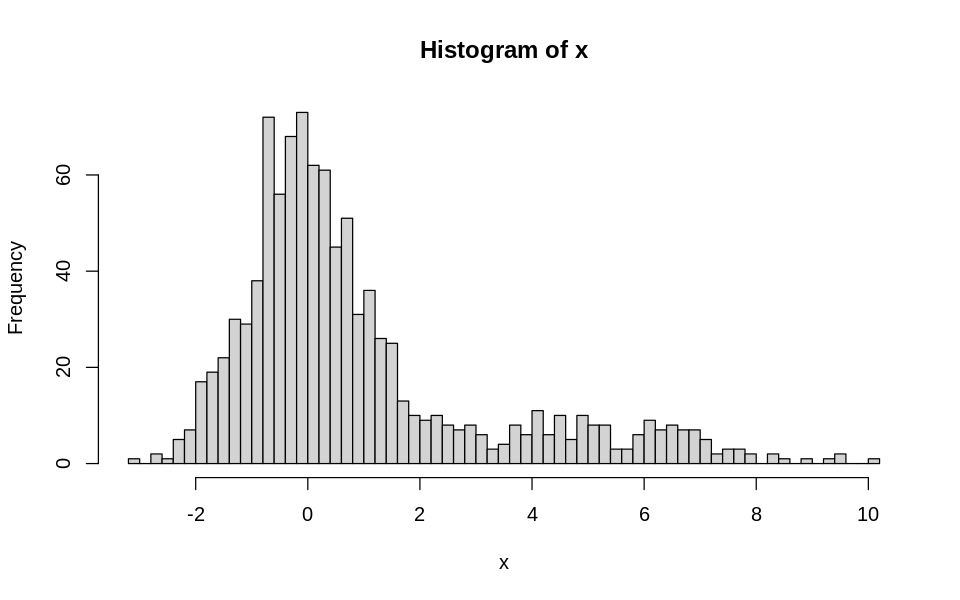

In [9]:
options(repr.plot.width=8,repr.plot.height=5)
alpha <- 0.8
sigma1 <- 1.0; sigma2 <- 2.0
mu1 <- 0.0; mu2 <- 5.0
n <- 1000
w <- rbinom(n,1,alpha)
x <- numeric(length=n)
n1 <- sum(w==1)
x[w==1] = rnorm(n1,mu1,sigma1)
x[w==0] = rnorm(n - n1,mu2,sigma2)
hist(x,br=50)

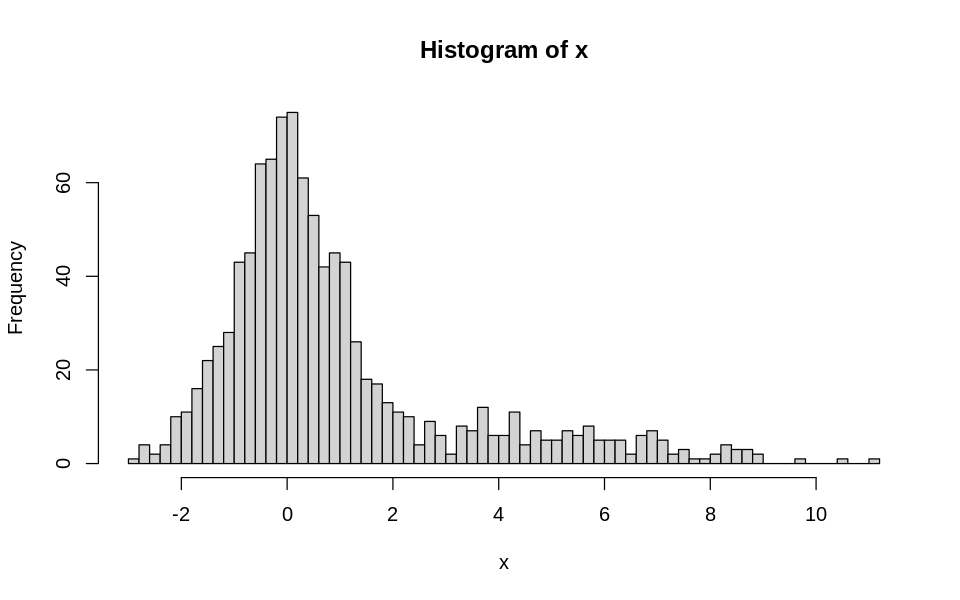

In [10]:
# Another way to implement gaussian mixture
Z = rnorm(n)        # uniform normal
x = numeric(length=n)
# reuse w defined above
idx1 = which(w==1)
idx2 = which(w==0)
x[idx1] = mu1 + sigma1*Z[idx1] # shift & scale
x[idx2] = mu2 + sigma2*Z[idx2]
hist(x,br=50)

## 5. Sampling from a multivariate normal

Let $V = U^TU$, and $\mathbf{z} \sim \mathcal{N}(0,I_n)$, then

$$\mathbf{x} = U^T\mathbf{z} + \mu \sim \mathcal{N}(\mu, U^TU) = \mathcal{N}(\mu, V)$$

In [11]:
#' rmvnorm_chol : Sample from a multivariate normal distribution 
#'                using Cholesky decomposition
#' @param n - number of random samples to generate
#' @param mu - (p x 1) vector of mean of MVN 
#' @param Sigma - (p x p) covariance matrix of MVN
#' @return a (n x p) matrix of MVN random samples
rmvnorm_chol <- function(n, mu, Sigma){
  p = length(mu)
  Z <- matrix(rnorm(n*p),nrow=p,ncol=n)
  U <- chol(Sigma)          ## perform Cholesky decomposition of covariance matrix 
  X <- mu + crossprod(U, Z) ## calculate U^T %*% z + mu for each column
  return(t(X))
}

Let $V = D^T\Lambda D$ be a eigencomposition, and $A = D^T\Lambda^{1/2}$ then

$$\mathbf{x} = A\mathbf{z} + \mu \sim \mathcal{N}(\mu, AA^T) = \mathcal{N}(\mu, V)$$

In [12]:
#' rmvnorm_eigen : Sample from a multivariate normal distribution 
#'                using eigen decomposition
#' @param n - number of random samples to generate
#' @param mu - (p x 1) vector of mean of MVN 
#' @param Sigma - (p x p) covariance matrix of MVN
#' @return a (n x p) matrix of MVN random samples
rmvnorm_eigen <- function(n, mu, Sigma){
  p = length(mu)
  eig_res = eigen(Sigma)  ## perform eigen-decomposition
  lambda = eig_res$value 
  V = eig_res$vectors
  Z <- matrix(rnorm(n*p,sd=sqrt(lambda)),nrow=p,ncol=n) ## make Z to have different variance based on eigenvalues
  X <- mu + V %*% Z  ## and multiply eigenvectors
  return(t(X))
}

Which method do you think it will be faster and accurate?

Let's simulate 5,000 sets of 1,000-dimensional MVN random variables

In [13]:
p <- 1000   ## Each MVN sample has 1,000 dimension
m <- rep(1,length=p)  ## mean is 1
rho <- 0.5  ## variance 1, off-diagnonal covariance 0.5
V <- matrix(rho,nrow=p,ncol=p)+(1-rho)*diag(p)
n <- 5000   ## 5,000 replicates

In [14]:
## compare Cholesky decomposition and Eigen-decomposition
system.time(x_chol <- rmvnorm_chol(n,mu = m, Sigma=V))
system.time(x_eigen <- rmvnorm_eigen(n,mu = m, Sigma=V))

   user  system elapsed 
  1.381   0.092   2.177 

   user  system elapsed 
  1.880   0.079   2.897 

In [15]:
## evaluate the covariance matrix from Cholesky decomposition
V = cov(x_chol)
print(summary(diag(V)))
print(summary(V[upper.tri(V)]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9252  0.9741  0.9851  0.9851  0.9963  1.0435 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4269  0.4765  0.4845  0.4845  0.4925  0.5383 


In [16]:
## evaluate the covariance matrix from Eigen decomposition
V = cov(x_eigen)
print(summary(diag(V)))
print(summary(V[upper.tri(V)]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9358  0.9836  0.9954  0.9955  1.0072  1.0510 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4320  0.4872  0.4954  0.4954  0.5036  0.5540 


In this particular case where all off-diagnoal elements have the same covariance, perhaps the fastest way to achieve it is to generate a ***shared*** random variable with variance $\rho$ and ***independent*** random variables with variance $1-\rho$ and simply adding them together.

In [17]:
# sample a multivariate normal distribution with symmetic positive correlation
rmvnorm_sym_pos_corr <- function(n, p, rho = 0.5, 
                                 mu = rep(0,length=p),
                                 sigma=rep(1,length=p)){
  Z = matrix(rnorm(n,sd=sqrt(rho)),nrow=p,ncol=n,byrow=TRUE)
  X = matrix(rnorm(n*p,sd=sqrt(1-rho)),nrow=p,ncol=n) + Z
  X = mu + sigma*X
  return(t(X))
}

In [18]:
system.time(x_sym <- rmvnorm_sym_pos_corr(n,p=p,rho=0.5,mu=m))

   user  system elapsed 
  0.784   0.034   0.914 

In [19]:
## evaluate the covariance matrix from fast heuristic
V = cov(x_sym)
print(summary(diag(V)))
print(summary(V[upper.tri(V)]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9575  1.0054  1.0171  1.0168  1.0288  1.0833 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4610  0.5082  0.5166  0.5166  0.5250  0.5728 


Finally, we can use known packages such as `mvtnorm()` to simulate from MVN.

In [20]:
install.packages("mvtnorm")
library(mvtnorm)
system.time(x_package <- mvtnorm::rmvnorm(n,mean=m,sigma=V))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



   user  system elapsed 
  1.280   0.076   1.356 

In [21]:
## evaluate the covariance matrix from mvtnorm() package
V = cov(x_package)
print(summary(diag(V)))
print(summary(V[upper.tri(V)]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9423  0.9969  1.0123  1.0127  1.0284  1.0919 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4360  0.5010  0.5126  0.5128  0.5243  0.5930 
